# Diabetes Health Assessment

## Analysis of Apple Health Data 

In this notebook, I explore my Apple health data in order to understand how well I am managing my diabetes.

I will focus on three main data frames, which will include insulin data, blood glucose data and data about my energy intake and expenditure (kcal burned, consumed, and the macronutrients in my diet).

After preprocessing the data (1), correcting for outliers (2), and adding new features to the dataframe (3), I will merge the data frames into one unique that the frame from which I will produce the visualisations (4) about my weekly average values for blood glucose levels, insulin sensitivity, energy balance, and the split of macronutrients.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Pre-Processing

In [2]:
energy = pd.read_csv('./source_files/energy.csv')
insulin = pd.read_csv('./source_files/insulin.csv')
glucose = pd.read_csv('./source_files/glucose.csv')

energy.info(), insulin.info(), glucose.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Date                            31 non-null     object 
 1   Active energy burned(kcal)      31 non-null     float64
 2   Basal energy burned(kcal)       31 non-null     float64
 3   Carbohydrates(g)                28 non-null     float64
 4   Distance walking / running(km)  31 non-null     float64
 5   Energy consumed(kcal)           26 non-null     float64
 6   Exercise time(min)              31 non-null     float64
 7   Fat total(g)                    26 non-null     float64
 8   Protein(g)                      26 non-null     float64
 9   Step count(count)               31 non-null     float64
dtypes: float64(9), object(1)
memory usage: 2.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 3 columns):
 #   Colu

(None, None, None)

## Fixing Data Types

- Turn the `Date` to datetime. This step is necessary to correctly display timeseries visualisations.

In [3]:
energy['Date'] = pd.to_datetime(energy['Date'])
insulin['Date'] = pd.to_datetime(insulin['Date'])
glucose['Date'] = pd.to_datetime(glucose['Date'])

In [4]:
energy.isna().sum()

Date                              0
Active energy burned(kcal)        0
Basal energy burned(kcal)         0
Carbohydrates(g)                  3
Distance walking / running(km)    0
Energy consumed(kcal)             5
Exercise time(min)                0
Fat total(g)                      5
Protein(g)                        5
Step count(count)                 0
dtype: int64

In [5]:
insulin.isna().sum()

Date                    0
Insulin delivery(IU)    0
Purpose                 0
dtype: int64

In [6]:
glucose.isna().sum()

Date                    0
Blood glucose(mg/dL)    0
dtype: int64

In [7]:
insulin['Purpose'].value_counts()

Bolus    75
Basal    29
Name: Purpose, dtype: int64

## Pre Processing

No null values in the datasets. However, some further preprocessing is needed on the insulin and the glucose dataframes.

### Insulin
There are two types of insulin in the dataset: 
- 'bolus', or rapid insulin. The one that is required to handle blood glucose spikes at meal time. This is the one I am interested in.
- 'basal', or slow insulin. This type of insulin can be tought as a 'stabiliser' acting on the background all throughout the day. It does not come diretcly into play to regulate the spikes at meal time.  

I am interested in the interplay of insulin and grams of carbohydrates on a daily basis, so the basal insulin can be ignored. 
I will then sum the bolus insulin to get the total units injected each day using the .groupby() and the .sum() methods.

### Glucose
For blood glucose levels, I am interested in the daily average. This can be computed using the .groupby() and the .mean() methods.

### Energy
I will compute the average values for `energy` dataframe, which contains info about the kcal expenditure/consumption, and the grams of macronutrients. 

### Merging 
The three dataframes, each containing the desired values on a daily basis, can be merged on on the `date` column.

In [8]:
# Compute total daily bolus insulin
bolus = insulin.query("Purpose=='Bolus'")
bolus = bolus[['Date', 'Insulin delivery(IU)']]
bolus.dropna(inplace=True)
bolus = bolus.groupby(pd.Grouper(key='Date', axis=0, freq='D')).sum().reset_index()

In [9]:
# Compute average daily blood glucose
glucose.dropna(inplace=True)
glucose = glucose.groupby(pd.Grouper(key='Date', axis=0, freq='D')).mean().reset_index()

# Compute average daily values in energy dataframe
energy = energy.groupby(pd.Grouper(key='Date', axis=0, freq='D')).mean().reset_index()

# Merge to master df
df_diabetes = glucose.merge(bolus, on='Date')
df = df_diabetes.merge(energy, on='Date')

## Result: MAIN DATAFRAME

In [10]:
df.head()

,Date,Blood glucose(mg/dL),Insulin delivery(IU),Active energy burned(kcal),Basal energy burned(kcal),Carbohydrates(g),Distance walking / running(km),Energy consumed(kcal),Exercise time(min),Fat total(g),Protein(g),Step count(count)
0,2022-12-16,120.768966,22.5,1332.085,1770.581,180.0,15.920,1523.0,193.0,38.0,88.0,20255.000
1,2022-12-17,181.564014,28.0,1180.656,1796.909,354.0,5.980,2328.0,195.0,41.0,133.0,7771.000
2,2022-12-18,189.787671,24.0,1136.759,1787.556,328.0,8.618,2266.0,200.0,52.0,112.0,11311.000
3,2022-12-19,128.986254,19.0,1486.760,1784.338,385.0,6.957,2338.0,160.0,25.0,133.0,9245.638
4,2022-12-20,135.232877,19.5,944.591,1797.242,290.0,5.816,NaN,154.0,NaN,NaN,7390.000


In [11]:
df.isna().sum()

Date                              0
Blood glucose(mg/dL)              0
Insulin delivery(IU)              0
Active energy burned(kcal)        0
Basal energy burned(kcal)         0
Carbohydrates(g)                  2
Distance walking / running(km)    0
Energy consumed(kcal)             4
Exercise time(min)                0
Fat total(g)                      4
Protein(g)                        4
Step count(count)                 0
dtype: int64

In [12]:
df.describe()

,Blood glucose(mg/dL),Insulin delivery(IU),Active energy burned(kcal),Basal energy burned(kcal),Carbohydrates(g),Distance walking / running(km),Energy consumed(kcal),Exercise time(min),Fat total(g),Protein(g),Step count(count)
count,30.000000,30.000000,30.000000,30.000000,28.000000,30.000000,26.000000,30.000000,26.000000,26.000000,30.000000
mean,141.207046,23.066667,1277.428300,1789.801533,304.607143,8.849767,1746.807692,203.966667,30.192308,85.307692,11252.899467
std,23.192437,5.824640,206.143499,11.405721,119.464651,2.582471,646.091574,33.041753,11.624179,36.633066,3193.020559
min,107.267123,13.000000,944.591000,1765.526000,43.000000,4.851000,266.000000,154.000000,2.000000,18.000000,6272.000000
25%,121.963393,19.625000,1150.078500,1783.826000,218.500000,6.597000,1222.750000,189.500000,23.250000,47.750000,8277.500000
50%,136.359629,22.500000,1214.171500,1790.569500,323.000000,8.708000,1973.000000,200.000000,32.000000,88.500000,11425.000000
75%,153.193671,26.250000,1440.062750,1795.502500,357.250000,9.829000,2259.750000,213.000000,37.750000,115.500000,12680.438500
max,190.955479,41.500000,1882.232000,1811.648000,690.000000,15.920000,2662.000000,302.000000,52.000000,133.000000,20255.000000


In [13]:
# Some outliers...
df['Carbohydrates(g)'].min(), df['Fat total(g)'].min()

(43.0, 2.0)

# 2. Outliers

## Remove outliers
There are a few outliers to handle, as well as a couple of null values in the carbohydrates and fats columns.

Indeed, sometimes it is good to eat in moderation, but 43 grams of `Carbohydrates` and 2 grams of `Fats` still look fishy to me...I know what I eat, and those values are just not possible.

The function below, `replace_outlier`, takes the dataframe and list of columns as arguments. 

In each column, it replaces the null values and the outliers with the median value. 
The outliers are found outside the upper and a lower bounds defined by 20th and 80th percentiles, to which I have added the interquartile range, multiplied by 1.5.

### Execution
I am applying the function to all the columns except the 'Date' column.

In [14]:
def replace_outliers(df, columns):
    """
    This function takes the 'df' and a list of columns as arguments.
    The syntax is: replace_outliers(df, ['col1', 'col2', ...])
    It replaces a column's outliers (detected outside the 1st and 3rd quartiles) 
    with the median value of that column.
    It returns the 'df' with the corrected values.

    """

    for column in columns:
        # Calculate the median value of the column
        median = df[column].median()
        mean = df[column].mean()
        std = df[column].std()

        # Calculate the lower and upper bounds for outliers
        q1, q3 = df[column].quantile([0.25, 0.75])
        iqr = q3 - q1

        # Calculate the lower and upper bounds
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)


        # Replace values outside the bounds with the median value
        df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)
        # Replace 0s with the median value
        df[column] = df[column].apply(lambda x: median if x == 0 else x)
        # Replace NaNs with the median value
        df[column] = df[column].fillna(df[column].median())
    return df

columns= df[df.columns[~df.columns.isin(['Date'])]]
df = replace_outliers(df, columns)

In [15]:
df.describe()

,Blood glucose(mg/dL),Insulin delivery(IU),Active energy burned(kcal),Basal energy burned(kcal),Carbohydrates(g),Distance walking / running(km),Energy consumed(kcal),Exercise time(min),Fat total(g),Protein(g),Step count(count)
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,141.207046,22.433333,1255.159617,1790.636317,293.600000,8.609367,1776.966667,197.066667,30.433333,85.733333,10958.566133
std,23.192437,4.669662,171.775335,10.443619,89.864112,2.210505,604.957193,16.498554,10.810861,34.030851,2704.140310
min,107.267123,13.000000,944.591000,1770.581000,43.000000,4.851000,266.000000,159.000000,2.000000,18.000000,6272.000000
25%,121.963393,19.625000,1150.078500,1783.944250,238.750000,6.597000,1309.500000,191.000000,24.000000,51.750000,8277.500000
50%,136.359629,22.500000,1208.624750,1790.953250,323.000000,8.663000,1973.000000,200.000000,32.000000,88.500000,11368.000000
75%,153.193671,25.500000,1424.101000,1795.502500,348.750000,9.809000,2239.500000,201.000000,37.000000,113.750000,12311.500000
max,190.955479,32.000000,1626.614000,1811.648000,449.000000,14.023000,2662.000000,228.000000,52.000000,133.000000,17419.000000


In [16]:
# Fixed! 
df['Carbohydrates(g)'].min(), df['Fat total(g)'].min()

(43.0, 2.0)

## Column names
Almost forgot...let's make those column names a bit more code friendly!

In [17]:
# Replace spaces with underscores and lowercase labels 
df.rename(columns = lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
df.head(1)

,date,blood_glucose(mg/dl),insulin_delivery(iu),active_energy_burned(kcal),basal_energy_burned(kcal),carbohydrates(g),distance_walking_/_running(km),energy_consumed(kcal),exercise_time(min),fat_total(g),protein(g),step_count(count)
0,2022-12-16,120.768966,22.5,1332.085,1770.581,180.0,8.708,1523.0,193.0,38.0,88.0,11425.0


# 3. Adding features

## Feature Engineering

There are some crucial features I want to analyse, but that are not in the dataframe. 
I will compute the following manually:
- `total_energy_burned(kcal)` as the sum of `active_energy_burned(kcal)` and `basal_energy_burned(kcal)`.
- `total_energy_balance` as the difference between `energy_consumed(kcal)` and `total_energy_burned(kcal)`.
- `insulin_to_carb_ratio` as the ratio of `carbohydrates(g)` and `insulin_delivery(iu)`.
- `insulin_sensitivity`as 1500/`insulin_delivery(iu)`


In [18]:
df['total_energy_burned(kcal)'] = df['active_energy_burned(kcal)'] + df['basal_energy_burned(kcal)']
df['total_energy_balance'] = df['energy_consumed(kcal)'] - df['total_energy_burned(kcal)']
df['insulin_to_carb_ratio'] = df['carbohydrates(g)']/df['insulin_delivery(iu)']

sensitivity=[]
for i in df['insulin_delivery(iu)']:
    sensitivity.append((1500 / i))
df['insulin_sensitivity'] = sensitivity

df.head()

,date,blood_glucose(mg/dl),insulin_delivery(iu),active_energy_burned(kcal),basal_energy_burned(kcal),carbohydrates(g),distance_walking_/_running(km),energy_consumed(kcal),exercise_time(min),fat_total(g),protein(g),step_count(count),total_energy_burned(kcal),total_energy_balance,insulin_to_carb_ratio,insulin_sensitivity
0,2022-12-16,120.768966,22.5,1332.085,1770.581,180.0,8.708,1523.0,193.0,38.0,88.0,11425.000,3102.666,-1579.666,8.000000,66.666667
1,2022-12-17,181.564014,28.0,1180.656,1796.909,354.0,5.980,2328.0,195.0,41.0,133.0,7771.000,2977.565,-649.565,12.642857,53.571429
2,2022-12-18,189.787671,24.0,1136.759,1787.556,328.0,8.618,2266.0,200.0,52.0,112.0,11311.000,2924.315,-658.315,13.666667,62.500000
3,2022-12-19,128.986254,19.0,1486.760,1784.338,385.0,6.957,2338.0,160.0,25.0,133.0,9245.638,3271.098,-933.098,20.263158,78.947368
4,2022-12-20,135.232877,19.5,944.591,1797.242,290.0,5.816,1973.0,200.0,32.0,88.5,7390.000,2741.833,-768.833,14.871795,76.923077


## One last thing on the time information 
For mere visualisation purposes, it might be good to have the number of the `year`, `month` and `week` for each row.

I will use these values to create the `weekly_df`, where all the features are averaged on a weekly basis.

Also, having these time information in separate columns could improve the visual display of graphs: for instance, I find it friendlier to have the month as text instead of number.

In [19]:
df['week'] = df['date'].dt.week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

import calendar
df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x])

# create weekly_df
weekly_df = df.copy()
weekly_df = weekly_df.groupby(['year','month','week']).mean().reset_index()

#convert week number to week time
import datetime
from dateutil.relativedelta import relativedelta
# update week column with new value
formatted_week = []
for week, month, year in zip(weekly_df.week, weekly_df.month, weekly_df.year):
    formatted_week.append(datetime.date(year, 1, 1) + relativedelta(weeks=+week))
weekly_df['week'] = formatted_week
weekly_df = weekly_df[:-1]

df.head()

/var/folders/hg/k9d7v0g9091fg29rbpmrpvm40000gp/T/ipykernel_28250/1709542267.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['date'].dt.week


,date,blood_glucose(mg/dl),insulin_delivery(iu),active_energy_burned(kcal),basal_energy_burned(kcal),carbohydrates(g),distance_walking_/_running(km),energy_consumed(kcal),exercise_time(min),fat_total(g),protein(g),step_count(count),total_energy_burned(kcal),total_energy_balance,insulin_to_carb_ratio,insulin_sensitivity,week,month,year
0,2022-12-16,120.768966,22.5,1332.085,1770.581,180.0,8.708,1523.0,193.0,38.0,88.0,11425.000,3102.666,-1579.666,8.000000,66.666667,50,Dec,2022
1,2022-12-17,181.564014,28.0,1180.656,1796.909,354.0,5.980,2328.0,195.0,41.0,133.0,7771.000,2977.565,-649.565,12.642857,53.571429,50,Dec,2022
2,2022-12-18,189.787671,24.0,1136.759,1787.556,328.0,8.618,2266.0,200.0,52.0,112.0,11311.000,2924.315,-658.315,13.666667,62.500000,50,Dec,2022
3,2022-12-19,128.986254,19.0,1486.760,1784.338,385.0,6.957,2338.0,160.0,25.0,133.0,9245.638,3271.098,-933.098,20.263158,78.947368,51,Dec,2022
4,2022-12-20,135.232877,19.5,944.591,1797.242,290.0,5.816,1973.0,200.0,32.0,88.5,7390.000,2741.833,-768.833,14.871795,76.923077,51,Dec,2022


In [20]:
weekly_df.head()

,year,month,week,blood_glucose(mg/dl),insulin_delivery(iu),active_energy_burned(kcal),basal_energy_burned(kcal),carbohydrates(g),distance_walking_/_running(km),energy_consumed(kcal),exercise_time(min),fat_total(g),protein(g),step_count(count),total_energy_burned(kcal),total_energy_balance,insulin_to_carb_ratio,insulin_sensitivity
0,2022,Dec,2022-12-17,164.040217,24.833333,1216.500000,1785.015333,287.333333,7.768667,2039.000000,196.000000,43.666667,111.000000,10169.000000,3001.515333,-962.515333,11.436508,60.912698
1,2022,Dec,2022-12-24,136.445055,20.857143,1262.826429,1796.304143,309.000000,9.042857,1772.428571,194.000000,32.428571,88.142857,11590.738857,3059.130571,-1286.702000,15.231324,74.247999
2,2022,Dec,2022-12-31,153.014374,26.500000,1285.013667,1791.906583,312.666667,7.243500,1870.333333,197.500000,31.333333,89.500000,9194.557167,3076.920250,-1206.586917,11.785955,57.683762
3,2023,Jan,2023-01-08,133.245716,19.071429,1213.040214,1788.487000,289.714286,9.502143,1810.857143,196.428571,29.714286,87.714286,12088.873857,3001.527214,-1190.670071,16.583668,84.040023
4,2023,Jan,2023-01-15,134.741219,22.583333,1252.702667,1784.886000,238.333333,8.644167,1370.833333,201.000000,18.833333,59.500000,10950.558667,3037.588667,-1666.755333,10.798185,67.395177


# 4. Data Visualisation

## The Key Metrics

I want an overview of some crucial health measurements:
- `blood_glucose(mg/dl)`: average on a weekly basis
- `insulin_sensitivity`: how much one unit of bolus insulin decreases blood glucose
- `insulin_to_carb_ratio`: how many grams of carbohydrates handled by one unit of bolus insulin. Another perspective on insulin sensitivity.
- `total_energy_burned(kcal)`, 
- `energy_consumed(kcal)`

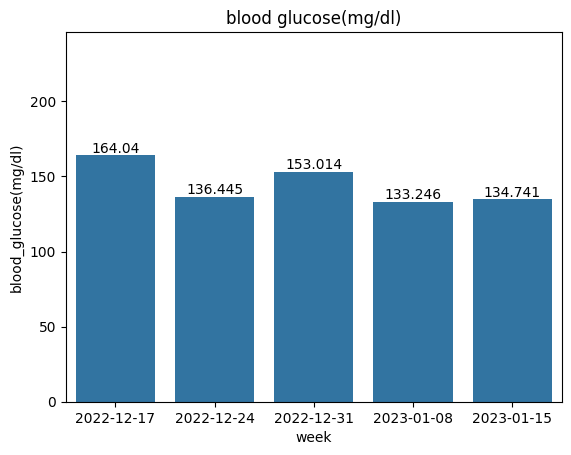

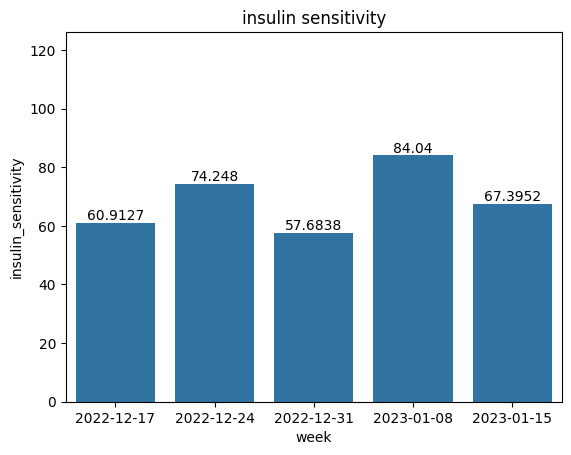

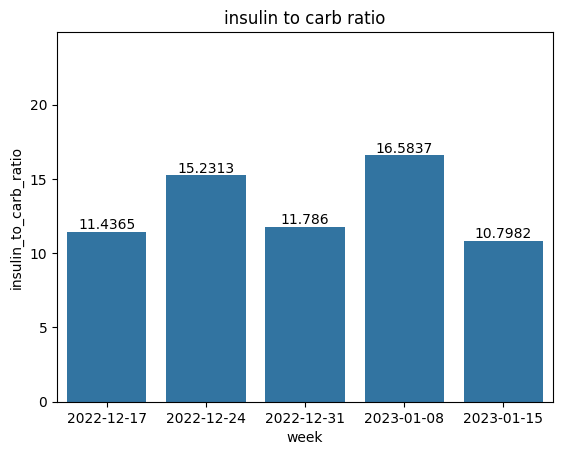

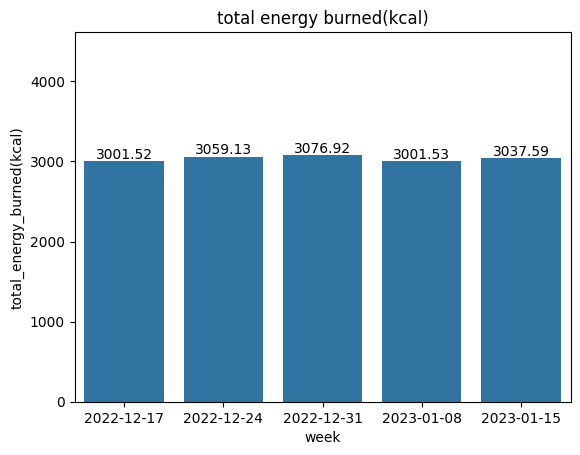

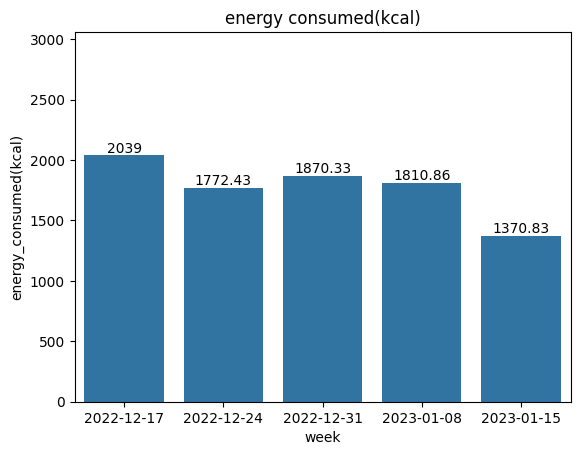

In [21]:
metrics = ['blood_glucose(mg/dl)', 'insulin_sensitivity', 'insulin_to_carb_ratio', 'total_energy_burned(kcal)', 'energy_consumed(kcal)']
#plt.figure(figsize=[20,15])
color = sns.color_palette()[0]
plt.subplots_adjust(hspace=0.3)

for m in metrics:
    ax = sns.barplot(data=weekly_df,
               x='week',
               y=m, 
               color=color)
    
    plt.title(m.replace('_', ' '))
    # increasing the y axis 1.5 times the maximum value of each metric
    plt.ylim(0, weekly_df[m].max()*1.5)
    plt.xticks(rotation=0)
    ax.bar_label(ax.containers[0])
    plt.show()

> **The average blood glucose (first graph) is decreasing**, which is extremely good.
> **The insulin sensitivity (2nd/3rd graph) varies within a defined range of 60 to 84**. The higher this value is, the better: it means that one unit of insulin is able to handle more carbohydrates, which makes the treatment more efficient. A low-fat diet helps to increase insulin sensitivity, so I will focus on this from now on, and report on the relationship between grams of fats, insulin sensitivity and blood glucose levels in the future.
> **The last two graphs suggest that I am in a calorie deficit! Am I?**

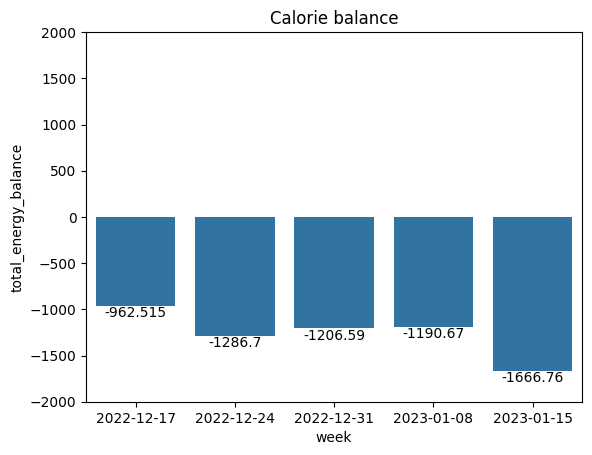

In [22]:
# Am I in a calorie deficit?

ax = sns.barplot(data=weekly_df,
               x='week',
               y='total_energy_balance', 
               color=color)
    
plt.title('Calorie balance')

# increasing the y axis limits 1.5 times the maximum value of each metric
plt.ylim(-2000, 2000)
plt.xticks(rotation=0)
ax.bar_label(ax.containers[0])
plt.show()

> **I very much am! 
Holy crap I need to eat more!**
> (What a wonderful excuse to add more volume to my dishes 😁)

# Split of Macronutrients

I am at a high-carb, low-fat diet. Am I succeeding? 

To understand the relative proportions of macronutrients in my diet, I will plot a 100% stacked bar chart showing the proportion of the type of macro in each week.

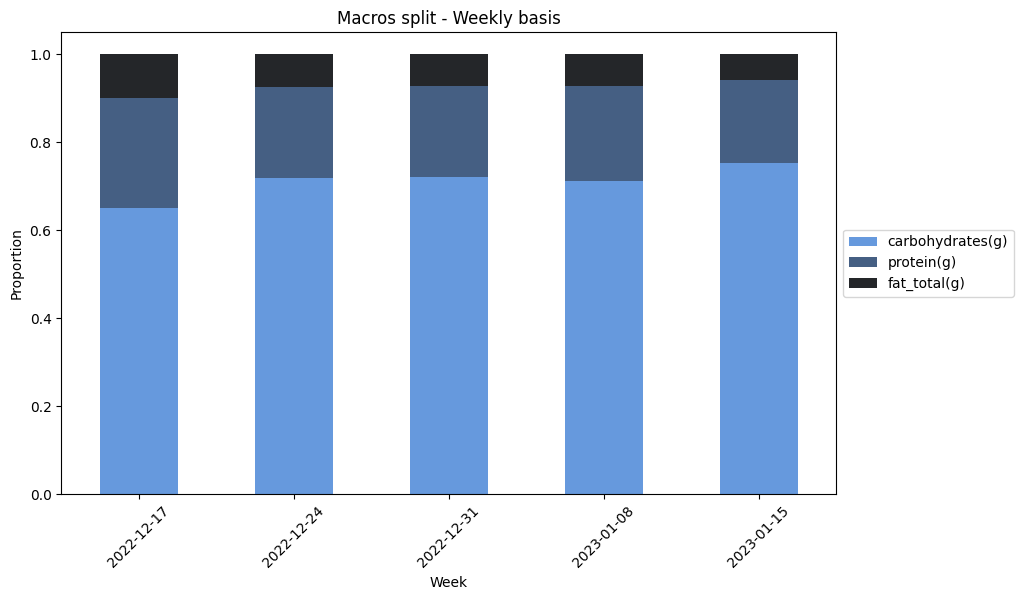

In [23]:
# compute frequency by row
weekly_df[['carbohydrates(g)','protein(g)','fat_total(g)']] = weekly_df[['carbohydrates(g)','protein(g)','fat_total(g)']].apply(lambda x: x/x.sum(), axis=1)

# prepare dataframe
macros = weekly_df[['week', 'carbohydrates(g)','protein(g)','fat_total(g)']].copy()
macros = macros.set_index('week')

results = macros.div(macros.sum(axis=1), axis=0)
color=sns.dark_palette("#69d", 
                       reverse=True, 
                       as_cmap=True)
# display graph
results.plot(kind='bar', 
        stacked=True, 
        colormap=color, 
        figsize=(10, 6))

plt.legend(loc='center left', 
           bbox_to_anchor=(1, 0.5), 
           ncol=1)

plt.xlabel("Week")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.title('Macros split - Weekly basis')
plt.show();

> As exepected, around 70-80% of my calories come from Carbohydrates, followed by circa 15% of protein, and a small amount of fats. I am happy with that.

## ∆% weekly change in average blood glucose

Here negative variations are desirable, because they imply a lower weekly blood glucose from the preious week.

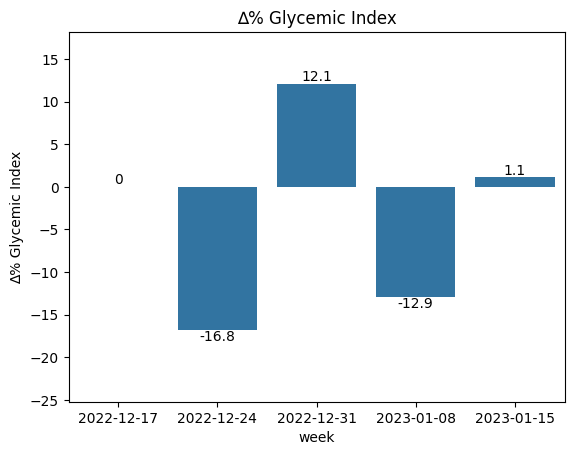

In [24]:
pct_change = ((weekly_df['blood_glucose(mg/dl)'].pct_change(periods=1))*100).round(1)
weekly_df['∆% Glycemic Index'] = pct_change
weekly_df['∆% Glycemic Index'] = weekly_df['∆% Glycemic Index'].fillna(0)

color = sns.color_palette()[0]
ax = sns.barplot(data=weekly_df,
               x='week',
               y='∆% Glycemic Index', 
               color=color)
    
plt.title('∆% Glycemic Index')

# increasing the y axis limits 1.5 times the maximum value of each metric
plt.ylim(weekly_df['∆% Glycemic Index'].min()*1.5, 
         weekly_df['∆% Glycemic Index'].max()*1.5)
plt.xticks(rotation=0)
ax.bar_label(ax.containers[0])
plt.show()

> Well...**the 3rd week of december marks an increase in blood glucose**.
> Not surprised at all! I may have ate a few more sweets here and there, with Christmas New Year's celebrations and all that. 
> I won't blame myself, the important thing is that I was back to normal the following week! 👍🏻